# Digital Musicology (DH-401)
## Assignment 1: Discovering meter
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

Rough outline
## 0. Data preparation
## 1. From musical score to metrical weights
## 2. From metrical weights to periodicities
## 3. From periodicities to time signature
## 4. Pipeline and evaluation for all scores

#TODO:
- consider grace notes as normal notes (replace 'duration' with 'nominal_duration',
because 'duration' is empty for them) -> check before/after impact to classification
- we also need to sum up durations of tied notes based on piece and staff and voice
- use appropriate method to extract frequencies/periodicities
- use appropriate method to infer time signature
- create simple classification accuracy measure with Ground Truth

In [88]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from scipy.signal import find_peaks, get_window
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier  
from sklearn import metrics

## 0. Data preparation

In [2]:
# This is the time unit of 'global_onset' used in the dataset
time_unit = 1/4

meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
meter_dataset = meter_dataset[['piece', 'staff', 'timesig', 'voice', 'global_onset', 'duration', 'tied', 'gracenote']]

# Ignore gracenotes for now
meter_dataset = meter_dataset[meter_dataset['gracenote'].isna()].drop(columns = ['gracenote'])

# Sort dataset
meter_dataset = meter_dataset.sort_values(by=['piece', 'staff', 'voice', 'global_onset']).reset_index(drop=True)

# Get maximum bar length of the dataset for analysis later on
timesignatures = [fractions.Fraction(timesig) for timesig in meter_dataset['timesig']]
max_bar_length = max(timesignatures)

In [3]:
%%time

untied_df = meter_dataset
tied_df = meter_dataset

# Aggregating ties (to verify if this is worse or better)
blocks = (tied_df.tied.ne(tied_df.tied.shift()) & tied_df.tied.ne(tied_df.tied.shift() - 2) & tied_df.tied.ne(tied_df.tied.shift() - 1)).cumsum()
tied_df = tied_df.groupby(blocks, as_index=False).agg({'piece':'first', 'staff':'first', 'voice':'first', 'timesig':'first', 'global_onset':'first', 'duration':'sum', 'tied':'first'})

# tied computation but not optimized
# tied_df = pd.DataFrame(columns=['piece', 'staff', 'voice', 'global_onset', 'duration', 'tied', 'timesig'])
# for index, row in wdf.iterrows():
#     if pd.isnull(row['tied']):
#         tied_df.loc[index]=row
#     if row['tied'] == 1:
#         tied_df.loc[index]=row
#         subindex = index
#         while wdf.loc[subindex + 1]['tied'].item() == 0:
#             tied_df.loc[index]['duration'] += wdf.loc[subindex + 1]['duration']
#             subindex += 1
#         else:
#             tied_df.loc[index]['duration'] += wdf.loc[subindex + 1]['duration']


CPU times: user 255 ms, sys: 41.4 ms, total: 296 ms
Wall time: 309 ms


In [4]:
#df = tied_df
df = untied_df

## 1. From musical score to metrical weights

Smallest note length in dataset: 1/32


,piece,staff,timesig,voice,global_onset,duration,tied
29108,K309-1,1,4/4,1,0,1/2,NaN
29109,K309-1,1,4/4,1,2,1/2,NaN
29110,K309-1,1,4/4,1,4,3/8,NaN
29111,K309-1,1,4/4,1,11/2,1/16,NaN
29112,K309-1,1,4/4,1,23/4,1/16,NaN
...,...,...,...,...,...,...,...
30108,K309-1,1,4/4,1,618,1/4,NaN
30109,K309-1,1,4/4,2,200,1/8,NaN
30110,K309-1,1,4/4,2,401/2,1/8,NaN
30111,K309-1,1,4/4,2,576,1/8,NaN


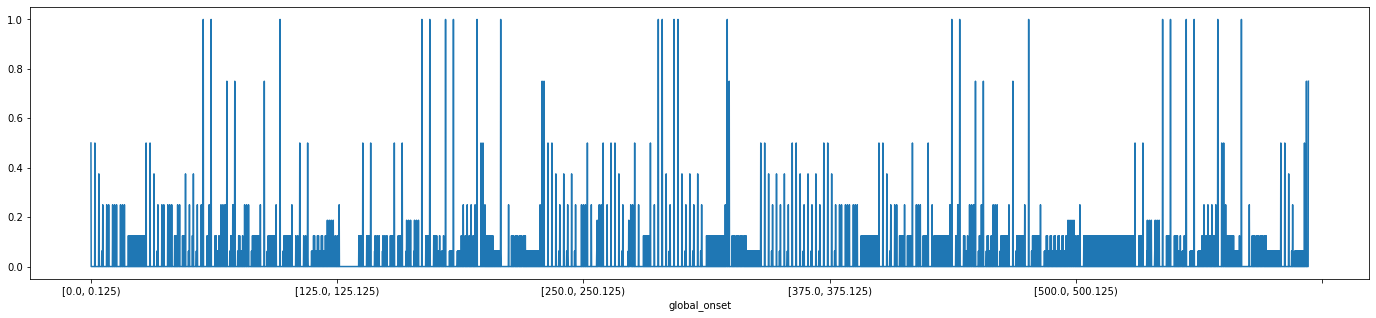

In [5]:
# Select one piece and staff (time signature may change per staff)
one_piece_staff = df[(df['piece'] == 'K309-1') & (df['staff'] == 1)]

# To fine-tune sampling, get minimum note duration among all notes in the piece/staff
min_note = float(one_piece_staff['duration'].min())
print("Smallest note length in dataset:", fractions.Fraction(min_note))

sampling_period = min_note/time_unit
total_piece_duration = one_piece_staff['global_onset'].max()

# Partition the global_onsets in bins
bins = np.arange(0, (total_piece_duration+sampling_period+1e-10), sampling_period)
binned_onsets = pd.cut(one_piece_staff['global_onset'], bins, right = False)

# Compute the sum of durations of all events with onsets in each bin
summed_durations = one_piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)
summed_durations.plot(figsize=(24,5));

one_piece_staff

In [ ]:
%%time

# For all pieces and staves (This operation takes around 2-3 minutes on our computer)

# Create dictionaries of total piece durations and smallest notes in each piece/staff
total_piece_durations_df = df.groupby(['piece','staff'])['global_onset'].max().apply(float)
minimum_note_durations_df = df.groupby(['piece','staff'])['duration'].min().apply(float)
total_piece_durations = total_piece_durations_df.to_dict()
minimum_note_durations = minimum_note_durations_df.to_dict()

summed_durations = {}
for key,value in total_piece_durations.items():
    piece_staff = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]

    min_note = minimum_note_durations[key]
    sampling_period = min_note/time_unit

    bins = np.arange(0, (value+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_staff['global_onset'], bins, right = False)
    summed_durations[key] = piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 1min 23s, sys: 485 ms, total: 1min 24s
Wall time: 1min 25s


Metrical weights of Piece: n09op59-3_02, Staff: 2, Time Signature: 6/8


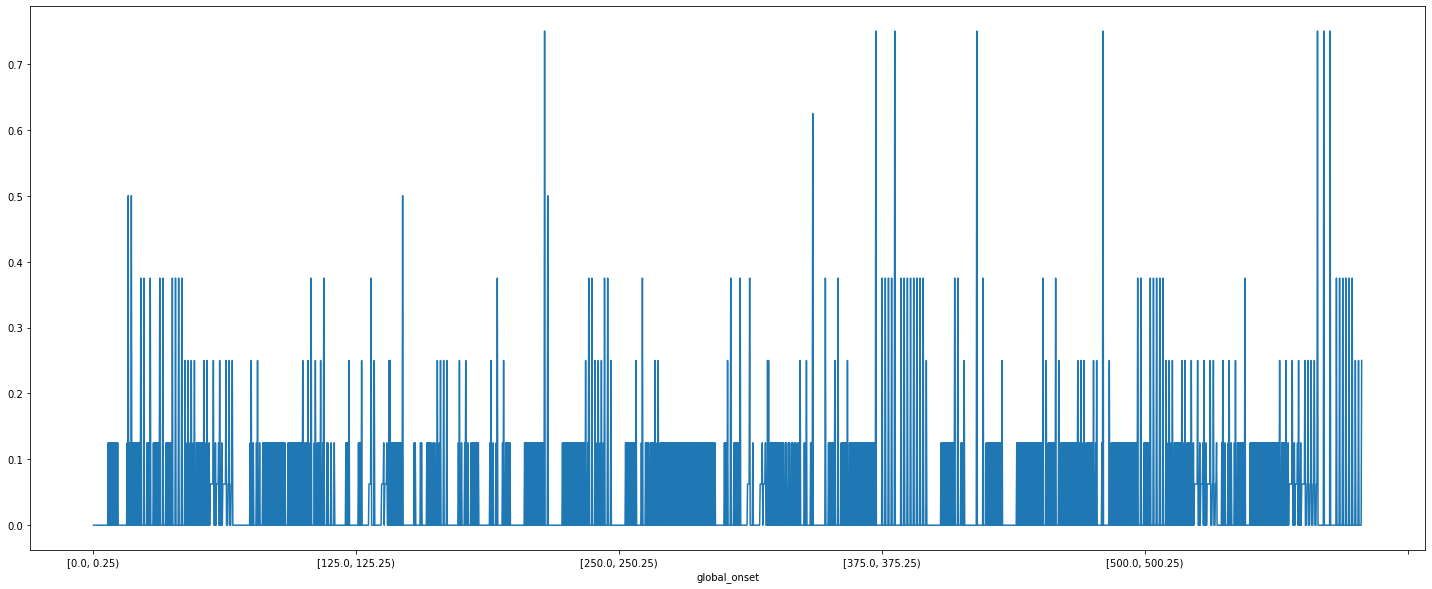

In [7]:
# Now we can plot the metrical weights of a random piece + staff
random_piece_staff = df[['piece', 'staff']].sample(n=1).to_records(index=False)
key = tuple(random_piece_staff[0])

# Get timesignature for reference
timesig = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]['timesig'].sample(n=1).item()

print("Metrical weights of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

# Plot metrical weights
summed_durations[key].plot(figsize=(25,10));


## 2. From metrical weights to periodicities

Periodicity analysis of Piece: n09op59-3_02, Staff: 2, Time Signature: 6/8


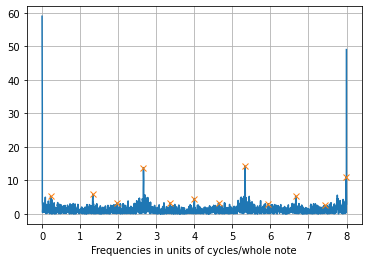

    frequency (cycles/whole note) period (1/f)  amplitude
7                        5.331123         3/16  14.341569
3                        2.665562          3/8  13.832270
11                       7.990054          1/8  11.078240
1                        1.332781          3/4   5.866483
9                        6.663904         3/20   5.388587
0                        0.225446       275/62   5.299912
5                        3.998342          1/4   4.588389
6                        4.641525        14/65   3.371687
4                        3.361790        25/84   3.323898
2                        1.975964        42/83   3.265589
8                        5.941152        16/95   3.046920
10                       7.426440         7/52   2.617796


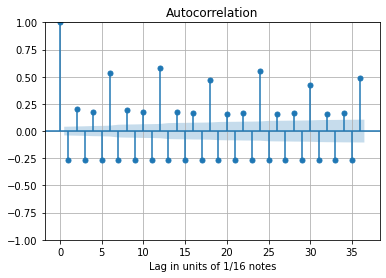

   lag (whole notes)  autocorrelation
12               3/4         0.583030
24               3/2         0.553839
6                3/8         0.534676
36               9/4         0.485433
18               9/8         0.471878
30              15/8         0.427371
2                1/8         0.204673
8                1/2         0.189743
10               5/8         0.178029
14               7/8         0.177403
4                1/4         0.177045
16                 1         0.170870
34              17/8         0.168953
28               7/4         0.168254
22              11/8         0.162160
26              13/8         0.160354
20               5/4         0.159811
32                 2         0.153352


In [8]:
print("Periodicity analysis of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

x = summed_durations[key].index.tolist()
y = summed_durations[key].tolist()

# Number of sample points
N = len(x)
# Sample spacing (in units of time_unit)
T = x[1].left

################################################################
# Window the signal to reduce spectral leakage in the FFT (a good practise)
window = get_window('hann', N)

# Compute Fourier transform of signal
yf = rfft(y * window)
xf = rfftfreq(N, T)
# Convert frequencies to units of cycles/whole note
xf = xf/time_unit
# Convert Fourier output to real-valued amplitudes
amplitudes = np.abs(yf)

# Find significant peaks (using min distance between neighbouring peaks)
peaks, _ = find_peaks(amplitudes, distance=N*.07)

##### Plot Right Fast Fourier Transform #####
plt.plot(xf, amplitudes)
plt.plot(xf[peaks], amplitudes[peaks], "x")
plt.xlabel('Frequencies in units of cycles/whole note')
plt.grid()
plt.show()

##### Get top frequencies (and periods) #####
fourier_peaks = np.array(tuple(zip(xf[peaks], 1/xf[peaks], amplitudes[peaks])))
# Create DataFrame
fourier_df = pd.DataFrame(fourier_peaks, columns = ['frequency (cycles/whole note)', 'period (1/f)', 'amplitude'])
# Convert period (1/f) to Fractions
fourier_df['period (1/f)'] = [fractions.Fraction(period).limit_denominator(100) for period in fourier_df['period (1/f)']]
# Sort in descending order
fourier_df_sorted = fourier_df.sort_values(by='amplitude', ascending=False)
print(fourier_df_sorted)

################################################################
# Create a window with the first few lags
# The window length will correspond to the maximum bar length (time signature) found in the dataset in the units of whole notes
nlags = math.ceil(max_bar_length / (T*time_unit))

##### Plot autocorrelations with respect to first few lags #####
plot_acf(y, lags=nlags)
plt.xlabel('Lag in units of {} notes'.format(fractions.Fraction(T*time_unit).limit_denominator(100)))
plt.grid()
plt.show()

##### Get top autocorrelations #####
autocorr = sm.tsa.acf(y, nlags=nlags)
# Convert lags in units of whole notes
converted_lags = range(len(autocorr)) * (T*time_unit)
# Create DataFrame
autocorr_df = pd.DataFrame(tuple(zip(converted_lags, autocorr)), columns = ['lag (whole notes)','autocorrelation'])
# Convert lags to Fractions
autocorr_df['lag (whole notes)'] = [fractions.Fraction(onset).limit_denominator(100) for onset in autocorr_df['lag (whole notes)']]
# Sort in descending order
autocorr_df_sorted = autocorr_df.sort_values(ascending=False, by='autocorrelation').where(autocorr_df.autocorrelation > 0).dropna().drop(0)
print(autocorr_df_sorted)



## 3. From periodicities to time signature

In [143]:
def top_autocorrelations(piece_staff, n_tops):
    x = summed_durations[piece_staff].index.tolist()
    y = summed_durations[piece_staff].tolist()
    
    # Number of sample points
    N = len(x)
    # Sample spacing (in units of time_unit)
    T = x[1].left
    
    ################################################################
    # Create a window with the first few lags
    # The window length will correspond to the maximum bar length (time signature) found in the dataset in the units of whole notes
    nlags = math.ceil(max_bar_length / (T*time_unit))

    ##### Get top autocorrelations #####
    autocorr = sm.tsa.acf(y, nlags=nlags)
    # Convert lags in units of whole notes
    converted_lags = range(len(autocorr)) * (T*time_unit)
    # Create DataFrame
    autocorr_df = pd.DataFrame(tuple(zip(converted_lags, autocorr)), columns = ['lag (whole notes)','autocorrelation'])
    # Convert lags to Fractions
    autocorr_df['lag (whole notes)'] = [fractions.Fraction(onset).limit_denominator(100) for onset in autocorr_df['lag (whole notes)']]
    # Sort in descending order
    autocorr_df_sorted = autocorr_df.sort_values(ascending=False, by='autocorrelation').where(autocorr_df.autocorrelation > 0).dropna().drop(0)
    tops = autocorr_df_sorted['lag (whole notes)'].head(n_tops).to_numpy()
    return tops
    

In [144]:
def top_frequencies(piece_staff, n_tops):
    x = summed_durations[piece_staff].index.tolist()
    y = summed_durations[piece_staff].tolist()

    # Number of sample points
    N = len(x)
    # Sample spacing (in units of time_unit)
    T = x[1].left

    ################################################################
    # Window the signal to reduce spectral leakage in the FFT (a good practise)
    window = get_window('hann', N)

    # Compute Fourier transform of signal
    yf = rfft(y * window)
    xf = rfftfreq(N, T)
    # Convert frequencies to units of cycles/whole note
    xf = xf/time_unit
    # Convert Fourier output to real-valued amplitudes
    amplitudes = np.abs(yf)

    # Find significant peaks (using min distance between neighbouring peaks)
    peaks, _ = find_peaks(amplitudes, distance=N*.07)

    ##### Get top frequencies (and periods) #####
    fourier_peaks = np.array(tuple(zip(xf[peaks], 1/xf[peaks], amplitudes[peaks])))
    # Create DataFrame
    fourier_df = pd.DataFrame(fourier_peaks, columns = ['frequency (cycles/whole note)', 'period (1/f)', 'amplitude'])
    # Convert period (1/f) to Fractions
    fourier_df['period (1/f)'] = [fractions.Fraction(period).limit_denominator(100) for period in fourier_df['period (1/f)']]
    # Sort in descending order
    fourier_df_sorted = fourier_df.sort_values(by='amplitude', ascending=False)
    tops = fourier_df_sorted['period (1/f)'].head(n_tops).to_numpy()
    return tops

In [235]:
ground_truth_df = df.groupby(['piece', 'staff'], as_index=False).first().drop(columns=['voice','global_onset','tied','duration'])

periodicities = []
# Number of top autocorrelations and number of top frequencies
n_tops = 7
for i in ground_truth_df.itertuples():
    piece = i.piece
    staff = i.staff
    piece_staff = (piece, staff)
    tops_autocorr = top_autocorrelations(piece_staff, n_tops)
    tops_freq = top_frequencies(piece_staff, n_tops)
    tops = [*tops_autocorr, *tops_freq]
    periodicities.append(tops)

In [247]:
features_df = pd.DataFrame(periodicities)
ground_truth_and_features_df = pd.concat([ground_truth_df, features_df], axis=1)
# Fill NaNs with mean of sample features or with 0s
#ground_truth_and_features_df = ground_truth_and_features_df.T.fillna(ground_truth_and_features_df.iloc[:,3:].mean(axis=1)).T
ground_truth_and_features_df = ground_truth_and_features_df.fillna(0)

X = ground_truth_and_features_df.iloc[:,3:].values
y = ground_truth_and_features_df.iloc[:,2].values

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)
model = RandomForestClassifier(n_estimators=100, bootstrap=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

wrong_predictions = y_test[y_test!=y_pred]
correct_predictions = y_test[y_test==y_pred]

unique_wrong, counts_wrong = np.unique(wrong_predictions, return_counts=True)
unique_correct, counts_correct = np.unique(correct_predictions, return_counts=True)

result_wrong = np.column_stack((unique_wrong, counts_wrong)) 
result_correct = np.column_stack((unique_correct, counts_correct)) 
print("wrong predicitons:", result_wrong)
print("right_predictions:", result_correct)

Accuracy: 0.7422680412371134
wrong predicitons: [['12/8' 2]
 ['2/2' 3]
 ['2/4' 4]
 ['3/4' 5]
 ['3/8' 2]
 ['4/4' 5]
 ['6/8' 3]
 ['9/8' 1]]
right_predictions: [['2/2' 16]
 ['2/4' 18]
 ['3/4' 23]
 ['3/8' 4]
 ['4/4' 8]
 ['6/8' 3]]


/Users/mukqs/Documents/Spring-2022/Digital-Musicology/Assignment-1/dm-meter-timesig/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


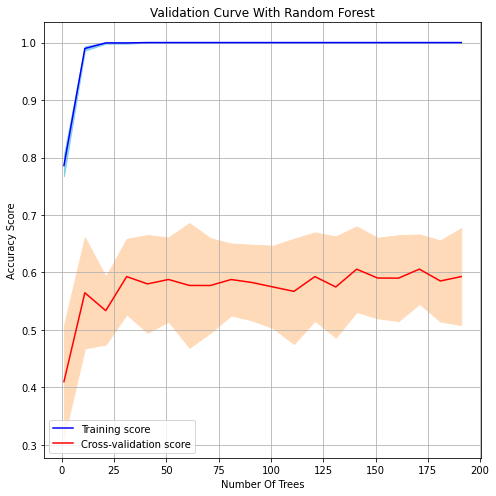

CPU times: user 15.5 s, sys: 142 ms, total: 15.7 s
Wall time: 15.7 s


In [254]:
%%time

# Cross-validation curve
n_trees_range=np.arange(1, 200, 10)

train_scores, test_scores = validation_curve(RandomForestClassifier(), X, y, param_name="n_estimators", param_range=n_trees_range, cv=5, scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(7,7))
plt.plot(n_trees_range, train_mean, label="Training score", color="blue")
plt.plot(n_trees_range, test_mean, label="Cross-validation score", color="red")

plt.fill_between(n_trees_range, train_mean - train_std, train_mean + train_std, color="skyblue")
plt.fill_between(n_trees_range, test_mean - test_std, test_mean + test_std, color="peachpuff")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()